# Predicting Titanic Survival Using Machine Learning
**Author:** Justin Zhao

```
"The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others."
```
This is a Machine Learning challenge/competition from Kaggle: https://www.kaggle.com/competitions/titanic/overview

## Project Overview
This notebook demonstrates the end-to-end machine learning pipeline used to achieve a top 5% score on the Titanic Kaggle leaderboard.

**Methodology:**
1.  **Preprocessing:** Custom feature engineering (Title extraction, Family size binning) and robust imputation.
2.  **Model Selection:** GridSearch tuning of three distinct classifiers:
    * **XGBoost** (Gradient Boosting)
    * **RandomForest** (Bagging)
    * **Logistic Regression** (Linear baseline)
3.  **Ensemble:** A `VotingClassifier` to combine predictions and reduce variance.
4.  **Conclusion:** Final thoughts and takeaways

## Problem Definition

> Given some information (name, age, gender, socio-economic class) of an individual aboard the RMS Titanic, can we predict whether or not they survived the shipwreck?

## Data

The data for this analysis was obtained from the Kaggle Titanic competition: 

https://www.kaggle.com/competitions/titanic/overview

This dataset is widely believed to be a subset of the "Titanic Passenger Survival Data" originally compiled by Thomas Cason and hosted by the Department of Biostatistics at Vanderbilt University.

It is important to note that while the data is based on the historical record from Encyclopedia Titanica, it is not an exhaustive list of everyone on board. Specifically, this dataset contains 1,309 records (split into train/test sets) and focuses exclusively on passengers, notably excluding the ~900 crew members who were also aboard the ship.

## Features

| Variable | Role | Type | Description | Units / Key | Missing Values |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **survival** | Target | Integer | Survival status | 0 = No, 1 = Yes | No |
| **pclass** | Feature | Integer | Ticket class (Proxy for SES) | 1 = 1st, 2 = 2nd, 3 = 3rd | No |
| **sex** | Feature | Object | Sex | male, female | No |
| **Age** | Feature | Float | Age in years | Years | **Yes** |
| **sibsp** | Feature | Integer | # of siblings / spouses aboard | Count | No |
| **parch** | Feature | Integer | # of parents / children aboard | Count | No |
| **ticket** | Feature | Object | Ticket number | Alphanumeric | No |
| **fare** | Feature | Float | Passenger fare | Currency | No |
| **cabin** | Feature | Object | Cabin number | Alphanumeric | **Yes** |
| **embarked** | Feature | Object | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton | **Yes** |

* **survival**: This is the target variable that indicates whether the passenger survived (1) or died (0).
* **pclass**: This represents the ticket class (1st, 2nd, or 3rd) and acts as a proxy for socio-economic status.
* **sex**: This records the gender of the passenger.
* **Age**: This is the passenger's age in years, which may be fractional for infants.
* **sibsp**: This counts the total number of siblings and spouses traveling with the passenger.
* **parch**: This counts the total number of parents and children traveling with the passenger.
* **ticket**: This is the unique alphanumeric ticket number printed on the passenger's ticket.
* **fare**: This records the monetary price the passenger paid for their journey.
* **cabin**: This lists the specific cabin number assigned to the passenger, though many values are missing.
* **embarked**: This indicates the port where the passenger boarded the ship (Cherbourg, Queenstown, or Southampton).

In [36]:
# IMPORTS
# regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# data manipulation pipeline (imputing, encoding)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer

# models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

# XGBoost
from xgboost import XGBClassifier

# model evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay

In [37]:
# LOAD DATA
df = pd.read_csv("data/titanic_train.csv")
df_test = pd.read_csv("data/titanic_test_no_labels.csv")

## 1. Preprocessing & Feature Engineering

Effective preprocessing was the primary driver of model performance in this project. Rather than throwing all features into the model at once, I adopted an iterative approach: establishing a baseline with simple imputation, and then sequentially adding engineered features to validate their impact on an **XGBoost** model.

### 1.1 Feature Evolution & EDA Findings
Below is a summary of the iterative improvements observed during the Exploratory Data Analysis phase.

#### **Phase 1: Baseline**
* **Strategy:** Basic categorical encoding of features `Sex`. Imputation of `Age` and `Fare` if necessary (not necessary for decision trees)
* **Logic:** Establish a control score using only raw numerical data and basic categorical encoding.
* **Cross-Validation Score:** `~82.3%`
* **AUC:** `~0.84`

#### **Phase 2: Title Extraction**
* **Strategy:** Extracted prefixes from the `Name` column (e.g., Mr., Mrs., Master., Dr.). grouped rare titles (Don, Rev, Major) into a single `Rare` category. Clean up noisy/unecessary features such as `Ticket`.
* **Logic:** Titles serve as a proxy for social status, gender, and age grouping simultaneously. 'Master' specifically helps identify male children who (unlike adult males) had high survival rates.
* **Cross-Validation Score:** `~82.8%`
* **AUC:** `~0.86`

#### **Phase 3: Family Survival Rate**
* **Strategy:** Calculated family sizes based on `Parch` and `Sibsp`; Calculated the survival rate of groups sharing the same ***Surname*** and `Ticket` price.
* **Logic:** Survival was rarely independent; if one family member survived, others were significantly more likely to survive (and vice versa) due to rescue boats keeping groups together.
* **Cross-Validation Score:** `~86.7%` *(+3.9% lift)*
* **AUC:** `~0.92` *(+0.06 lift)*

---

### 1.2 Final Preprocessing Pipeline
Based on these findings, the final model incorporates all successful features. It uses a custom transformer pipeline to handle all data types and feature engineering.

In [38]:
from src.preprocessing import create_family_survival_feature
X_train_full, X_test_full = create_family_survival_feature(df, df_test)

In [39]:
np.random.seed(12)

X = X_train_full.drop("Survived", axis=1)
y = X_train_full["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [40]:
from src.preprocessing import feat_eng_transformer

feat_eng_functionTransformer = feat_eng_transformer()

from src.preprocessing import title_transformer
from src.preprocessing import sex_transformer
from src.preprocessing import cabin_transformer

clean_features = ["Pclass", "Fare", "Age", "FamilySize", "Family_Survival"]

final_preprocessor = ColumnTransformer(
    transformers=[
        ("sex", sex_transformer(), ["Sex"]),
        ("cabin", cabin_transformer(), ["Cabin"]),
        ("title", title_transformer(), ["Title"]),
        ("clean_cols", "passthrough", clean_features)
    ], 
remainder="drop")

In [41]:
from src.preprocessing import age_binning_transformer
from src.preprocessing import fare_bin_transformer
from src.preprocessing import family_size_transformer
from src.preprocessing import cat_transformer

logreg_preprocessor = ColumnTransformer(
    transformers=[
        ("sex", sex_transformer(), ["Sex"]),
        ("cabin", cabin_transformer(), ["Cabin"]),
        ("title", title_transformer(), ["Title"]),
        ("age", age_binning_transformer(), ["Age"]),
        ("fams_size", family_size_transformer(), ["FamilySize"]),
        ("fare", fare_bin_transformer(), ["Fare"]),
        ("cat", cat_transformer(), ["Pclass","Family_Survival"])
    ], 
remainder="drop")

## 2. Model Training & Hyperparameter Tuning

With the feature engineering finalized, we move to model selection and tuning. To ensure a robust final ensemble, I selected three distinct algorithms that learn from the data in fundamentally different ways: **Gradient Boosting (XGBoost)**, **Bagging (Random Forest)**, and a **Linear Baseline (Logistic Regression)**.

### 2.1 Strategy: GridSearch & Cross-Validation
I utilized `GridSearchCV` for hyperparameter tuning on each model. I trained and cross-validated each model to find the optimal balance between bias and variance.

#### **A. Tree-Based Models (XGBoost & Random Forest)**
* **Role:** These models are excellent at capturing non-linear relationships and interactions (e.g., *Age* vs *Class*) without explicit feature engineering.
* **Preprocessing:** Tree models are generally robust to unscaled data and can handle raw feature distributions well.

#### **B. The Linear Baseline (Logistic Regression)**
* **Role:** Provides a probabilistic baseline. If a complex tree model can't beat this, the signal is likely linear.
* **Pipeline Adaptation:** Unlike trees, Logistic Regression **required a distinct pipeline**.
    * **Binning is Critical:** Features need to be either binned or scaled, features like *Age*, *Fare* need to be binned and imputed for LogReg. 

---

### 2.2 Hyperparameter Tuning Implementation
The code below defines the specific parameter grids for each model and grid search results.

In [42]:
param_grid_xgb = [
    {
        'model': [XGBClassifier()],
        'model__n_estimators': [800, 1000, 1200],
        'model__learning_rate': [0.005, 0.007],
        'model__max_depth': [3, 4],
        'model__subsample': [0.5],
        'model__colsample_bytree': [0.5],
        'model__gamma': [0.1, 0.2],
        'model__min_child_weight': [4, 5],
        'model__reg_alpha' : [1],
        'model__reg_lambda' : [2]
    }
]
param_grid_rf = [
    {
        'model': [RandomForestClassifier()],
        'model__n_estimators': [800, 1000, 1200],
        'model__max_depth': [2, 3,4],
        'model__min_samples_split': [ 2,3,4, 5],
        'model__min_samples_leaf': [3, 4],
        'model__bootstrap': [True]
    }
]
param_grid_lr = [
    {
        'model': [LogisticRegression()],
        'model__C': [ 0.002, 0.1, 1],
        'model__solver': ["lbfgs", "liblinear"]
    }
]

🔍 Tuning hyperparameters...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
✅ Best Params: {'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...), 'model__colsample_bytree': 0.5, 'model__gamma': 0.1, 'model__learning_rate': 0.005, 'model__max_depth': 4, 'model__min_chil

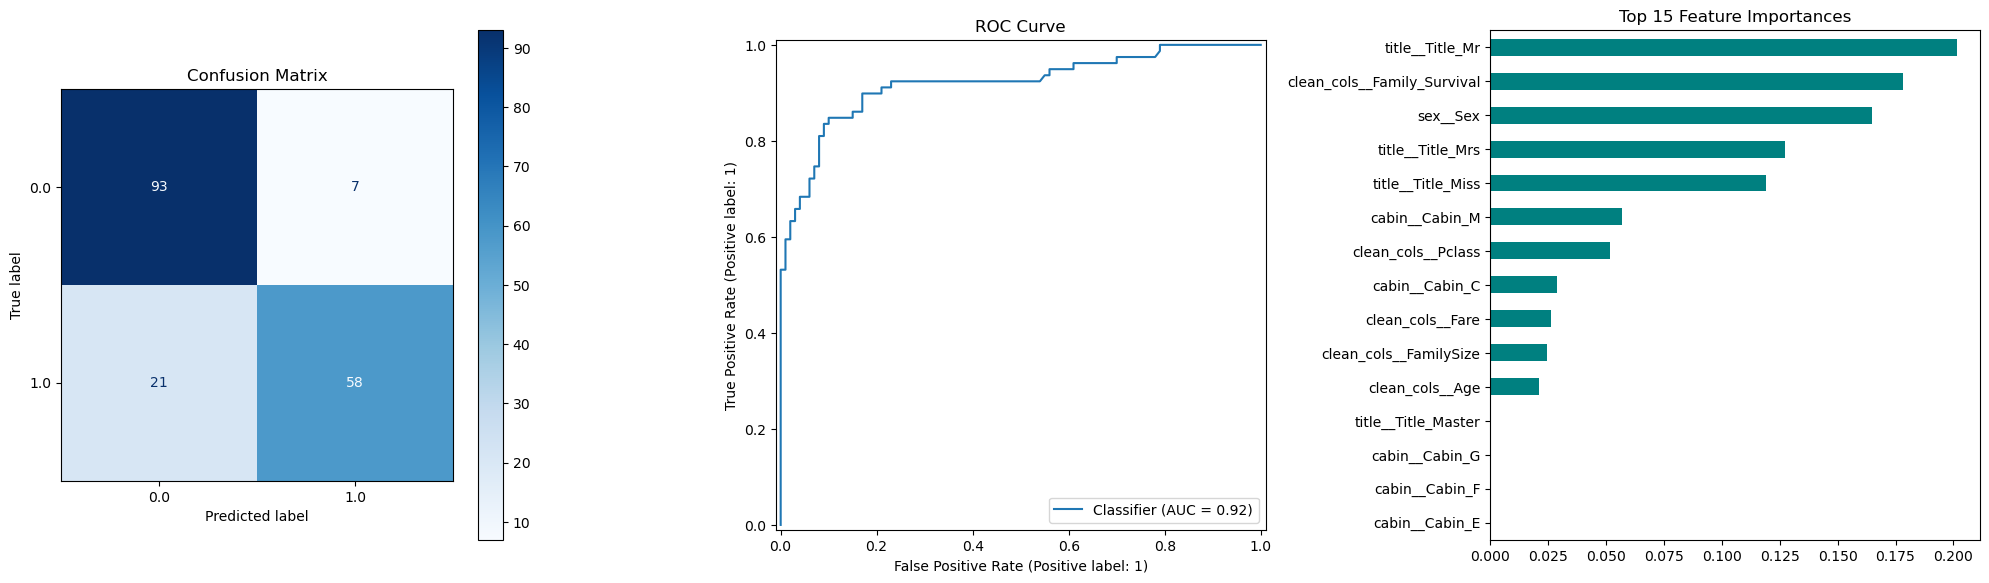

In [43]:
from src.evaluation import train_and_evaluate
xgb_model = train_and_evaluate(final_preprocessor, X_train, X_test, y_train, y_test, X=X, y=y, feature_engineering=feat_eng_functionTransformer, param_grid=param_grid_xgb)

🔍 Tuning hyperparameters...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
✅ Best Params: {'model': RandomForestClassifier(), 'model__bootstrap': True, 'model__max_depth': 4, 'model__min_samples_leaf': 3, 'model__min_samples_split': 4, 'model__n_estimators': 1000}

📊 CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.82      0.93      0.87       100
         1.0       0.89      0.73      0.81        79

    accuracy                           0.84       179
   macro avg       0.85      0.83      0.84       179
weighted avg       0.85      0.84      0.84       179


CROSS-VALIDATED SCORES ON X AND Y
{'accuracy': np.float64(0.8574665746029753), 'precision': np.float64(0.9001420106048437), 'recall': np.float64(0.7134271099744246), 'f1': np.float64(0.7907548065300937)}


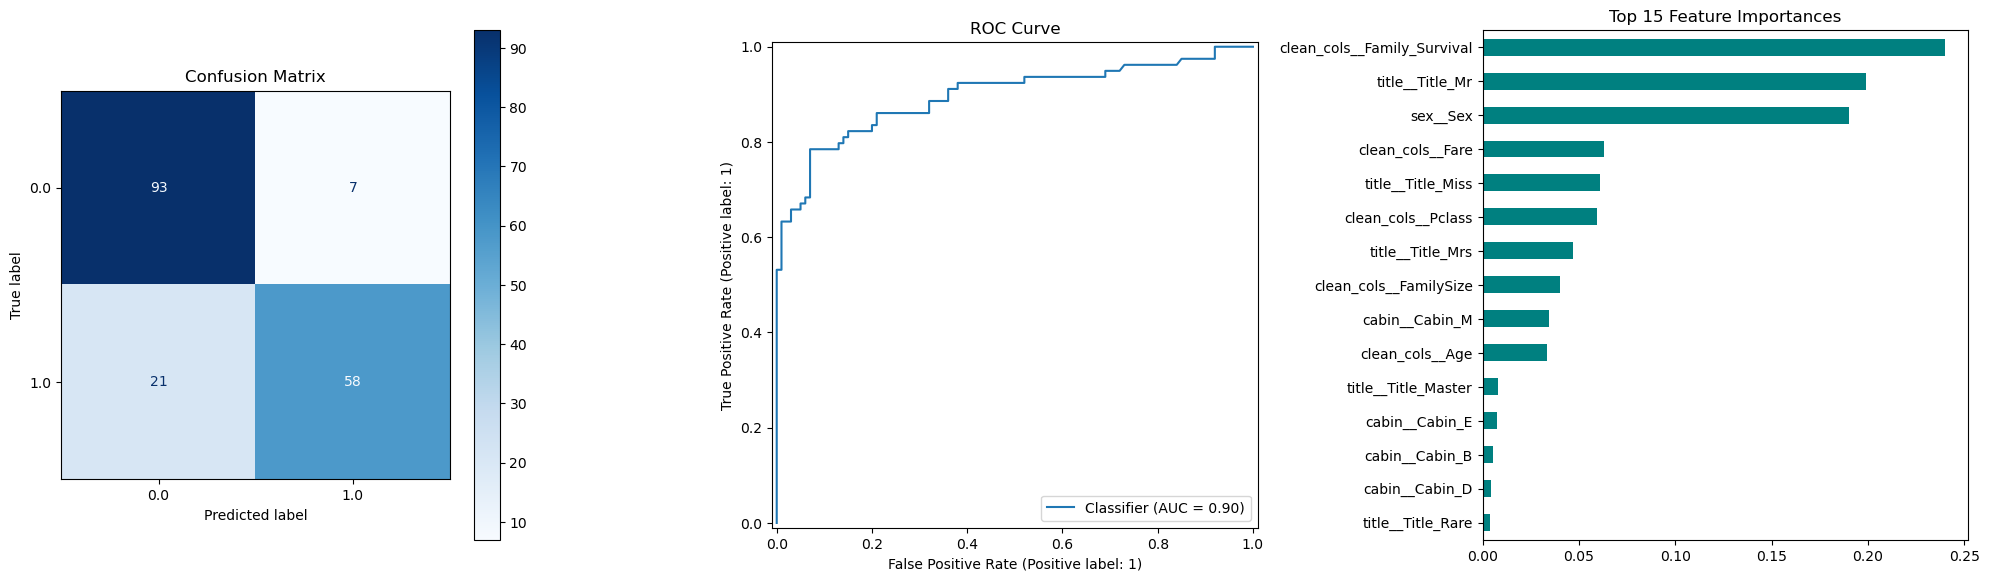

In [44]:
rf_model = train_and_evaluate(final_preprocessor, X_train, X_test, y_train, y_test, X=X, y=y, feature_engineering=feat_eng_functionTransformer, param_grid=param_grid_rf)

🔍 Tuning hyperparameters...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
✅ Best Params: {'model': LogisticRegression(), 'model__C': 0.1, 'model__solver': 'liblinear'}

📊 CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.84      0.92      0.88       100
         1.0       0.88      0.77      0.82        79

    accuracy                           0.85       179
   macro avg       0.86      0.85      0.85       179
weighted avg       0.86      0.85      0.85       179


CROSS-VALIDATED SCORES ON X AND Y
{'accuracy': np.float64(0.8687025296591552), 'precision': np.float64(0.871998972831301), 'recall': np.float64(0.7748081841432225), 'f1': np.float64(0.818995984108791)}
⚠️ Could not plot feature importance: 'LogisticRegression' object has no attribute 'feature_importances_'


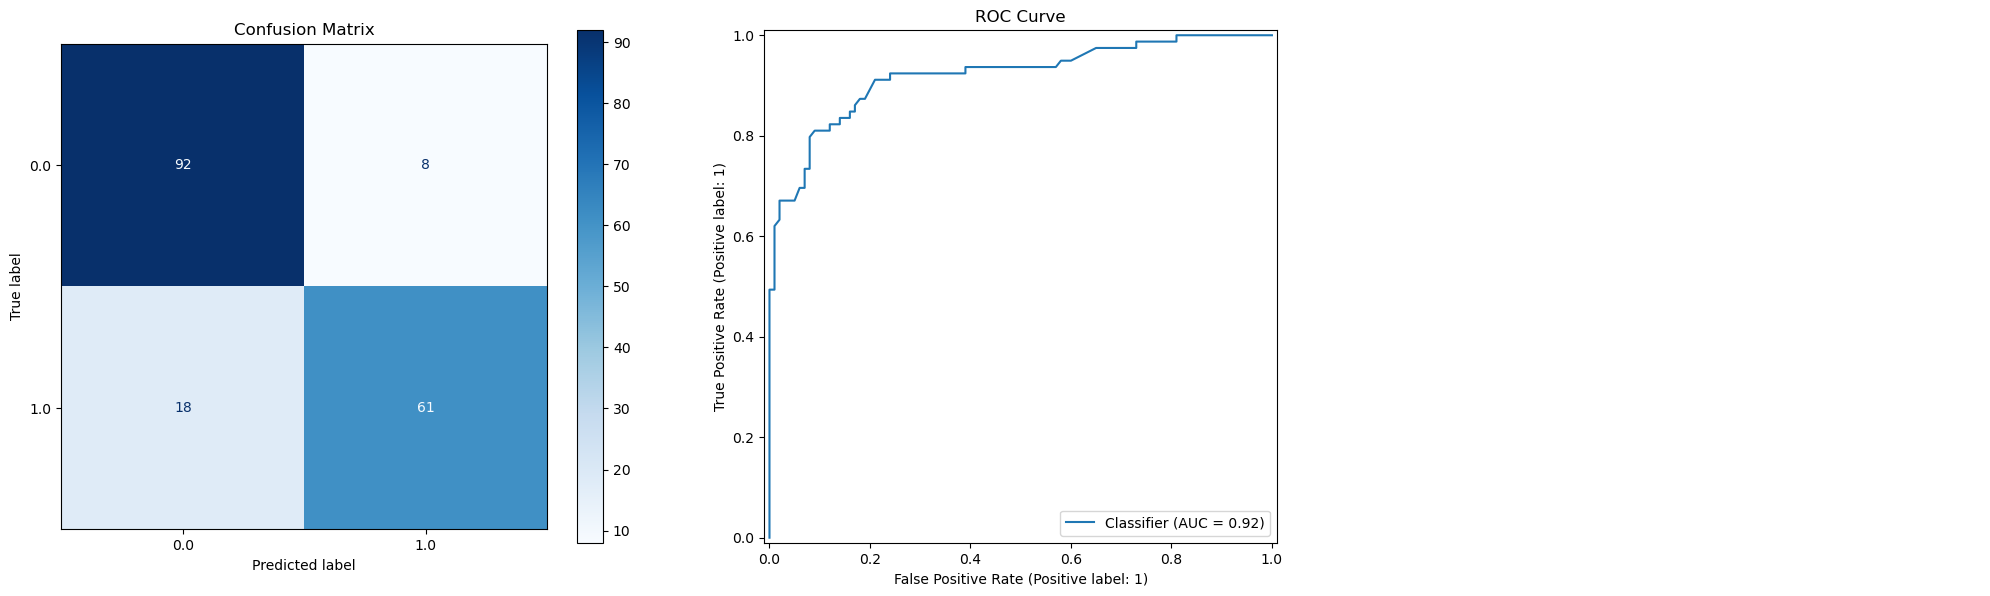

In [45]:
lr_model = train_and_evaluate(logreg_preprocessor, X_train, X_test, y_train, y_test, X=X, y=y, feature_engineering=feat_eng_functionTransformer, param_grid=param_grid_lr)

### 2.3 Best Models and Overfitting Prevention
The issue with the grid searched hyperparameters is that the best cross-validated results still leaned towards overfitting. 

I had to reduce the size of the hyperparmeter grid and "force" models to generalize more by having low max depth, higher min samples for splitting, lower learning rate, etc. 

Then the final adjustments came from finding parameters which lead to the lowest delta between prediction accuracy on the training split and prediction accuracy on the test split. (High training split accuracy means the model just "memorized" the training data).

**Below are the final models**

In [46]:
best_xgb_model = Pipeline(steps=[
    ('feat_eng', feat_eng_functionTransformer),
    ('preprocessor', final_preprocessor),
    ('model', XGBClassifier(
        n_estimators=800,
        learning_rate=0.005,
        max_depth=4,            # keeps trees shallow
        min_child_weight=4,     # prevents learning from individual cases
        gamma=0.1,              # required improvement level for a split
        subsample=0.5,          # each tree sees only a random 50% of the rows of data
        colsample_bytree=0.5,   # each tree sees only a random 50% of features - help spread feature importance (prevents only learning "family survival")
        reg_alpha=1,            # High L1 Reg
        reg_lambda=2,           # High L2 Reg
    ))
])

best_xgb_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('feat_eng', ...), ('preprocessor', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function eng...t 0x1686d39c0>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword arguments 

In [47]:
best_rf_model = Pipeline(steps=[
    ('feat_eng', feat_eng_functionTransformer),
    ('preprocessor', final_preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=1000,
        max_depth=4,            # keeps trees shallow
        min_samples_split=4,    # prevents learning from individual cases
        min_samples_leaf=4      # reduces outliers
    ))
])

best_rf_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('feat_eng', ...), ('preprocessor', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function eng...t 0x1686d39c0>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword arguments 

In [48]:
best_lr_model = Pipeline(steps=[
    ('feat_eng', feat_eng_functionTransformer),
    ('preprocessor', logreg_preprocessor),
    ('model', LogisticRegression(
        C=0.1,                  # strong regularization to reduce overfitting
        solver="liblinear"      # best optimizer for smaller datasets
    ))
])

best_lr_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('feat_eng', ...), ('preprocessor', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function eng...t 0x1686d39c0>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword arguments 

## 3. Ensemble and Saving
After finalizing the tuning of the three models, we will combine them into a voting ensemble, save the models, and create a submission.

### 3.1 Voting Ensemble
The best results I found were when using a `Hard` voting ensemble. We will fit and score this final model.

In [49]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr_branch', best_lr_model),
        ('xgb_branch',best_xgb_model),
        ('rf_branch', best_rf_model)
    ],
    voting='hard'
)

voting_clf.fit(X_train, y_train)

,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingClassifier`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('lr_branch', ...), ('xgb_branch', ...), ...]"
,"voting voting: {'hard', 'soft'}, default='hard'If 'hard', uses predicted class labels for majority rule voting.Else if 'soft', predicts the class label based on the argmax ofthe sums of the predicted probabilities, which is recommended foran ensemble of well-calibrated classifiers.",'hard'
,"weights weights: array-like of shape (n_classifiers,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted class labels (`hard` voting) or class probabilitiesbefore averaging (`soft` voting). Uses uniform weights if `None`.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",None
,"flatten_transform flatten_transform: bool, default=TrueAffects shape of transform output only when voting='soft'If voting='soft' and flatten_transform=True, transform method returnsmatrix with shape (n_samples, n_classifiers * n_classes). Ifflatten_transform=False, it returns(n_classifiers, n_samples, n_classes).",True
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function eng...t 0x1686d39c0>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True


In [50]:
from src.evaluation import cross_validated_scores
print(voting_clf.score(X_train, y_train))
print(voting_clf.score(X_test, y_test))
print(cross_validated_scores(voting_clf, X, y))

0.8862359550561798
0.8435754189944135
{'accuracy': np.float64(0.8664365074383278), 'precision': np.float64(0.8889477257681081), 'recall': np.float64(0.7454816709292412), 'f1': np.float64(0.8082024769152701)}


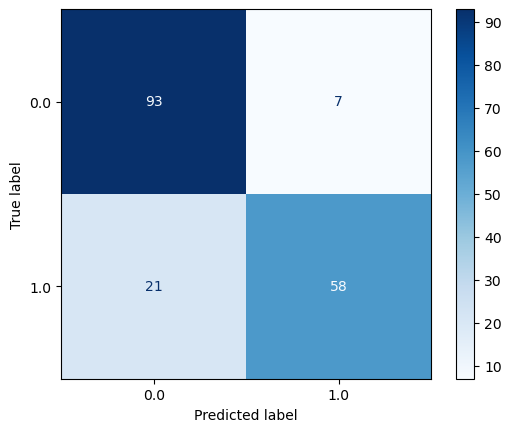

In [51]:
y_preds = voting_clf.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_preds, cmap='Blues')

### 3.2 Saving and Submitting

In [52]:
import pickle
# save our model using pickle

pickle.dump(voting_clf, open("./models/titanic_voting_model_final.pkl", "wb"))

loaded_pickle_model = pickle.load(open("./models/titanic_voting_model_final.pkl", "rb"))

test_predictions = loaded_pickle_model.predict(X_test_full)

# create a DataFrame with the two required columns
submission = pd.DataFrame({
    "PassengerId": df_test["PassengerId"], 
    "Survived": test_predictions           
})

submission["Survived"] = submission["Survived"].astype(int)

# save it to a CSV file (index=False)
submission.to_csv("./submissions/titanic_submission_voting_final.csv", index=False)

## 4. Conclusion & Key Insights

This project demonstrated that **feature engineering and data understanding are the primary drivers of performance**. By moving beyond raw data and creating sociologically relevant features (like *Title* and *Family Survival*), the models were able to capture patterns that raw training missed.

### 4.1 Feature Importance & Data Strategy
* **"Title":** One of the most predictive features was the extracted *Title*. It acted as a powerful proxy for Age, Gender, and Social Class simultaneously.
* **Redundancy Reduction:** A key lesson was the danger of **multicollinearity**. Training on raw `SibSp` and `Parch` alongside the derived `FamilySize` feature introduced noise. Dropping redundant columns improved model stability.
* **Family Survival:** The strongest boost came from grouping passengers by Ticket/Surname. The survival of family is highly predictive, but to the point where it was highly important to ensure models didn't "overlearn" and memorize the training data about family survival. In the real testing data, the family survival is commonly unknown. 

### 4.2 Model Performance & Tuning
* **Tree-Based vs. Linear:** While *XGBoost* and *RandomForest* provided excellent baselines out-of-the-box, *Logistic Regression* proved very strong after feature engineering, tuning, and robustly "massaging" the data for it. This suggests that the problem is pretty linear.
* **Combating Overfitting:** The small size of the Titanic dataset makes it prone to memorization especially after `Family_Survival` was introduced.
    * For **XGBoost** and **RandomForest**, limiting the `max_depth` and increasing samples needed for new trees was critical to reducing the "memorization" effect.
    * For **LogisticRegression**, it was important to set a high regularization C.

### 4.3 Final Lessons
* **Iterative Experimentation:** The best results required a cycle of *Hypothesis -> Feature Creation -> Validation -> Error Analysis*.
* **Tool Stack Mastery:** This project solidified my understanding of the entire ML lifecycle—from using `pandas` for data manipulation to building custom `sklearn` pipelines for training models, and evaluating them.
* **Domain Knowledge:** A key realization was that survival probability was determined by social hierarchies (Title, Sex, Class) and family structures. By helping to encode this domain knowledge into the dataset, I bridged the gap between human intuition and machine learning. This shows how the most powerful models are those that combine rigorous statistical tuning with a deep understanding of the problem.